In [1]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
from PIL import Image


def load_image(image_path, scale=0.5):
    img = cv2.imread(image_path)  # 讀取圖片
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 轉換為 RGB
    img = cv2.resize(img, (0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_AREA)  # 縮小解析度
    
    h, w, _ = img.shape
    coordinates = np.array([[i, j] for i in range(h) for j in range(w)])
    colors = img.reshape(-1, 3)  # 展平顏色資訊
    return coordinates, colors, h, w

coordinates1, colors1, h1, w1 = load_image("image1.png", scale=0.5)  
coordinates2, colors2, h2, w2 = load_image("image2.png", scale=0.5)


In [2]:
def rbf_kernel(coordinates, colors, gamma_s, gamma_c):

    spatial_dist = np.linalg.norm(coordinates[:, np.newaxis] - coordinates, axis=2) ** 2
    # Calculate color distance (squared)
    color_dist = np.linalg.norm(colors[:, np.newaxis] - colors, axis=2) ** 2
    # Compute the RBF kernel
    kernel = np.exp(-gamma_s * spatial_dist) * np.exp(-gamma_c * color_dist)
    return kernel


def kernel_k_means(K, n_clusters, max_iter=30):
    n = K.shape[0]
    cluster_assignments_history = []  # Store the cluster assignments for each iteration
    cluster_assignments = np.random.choice(n_clusters, n)
    for iteration in range(max_iter):
        # Compute the sum of similarities for each cluster
        cluster_sums = np.array([np.sum(K[:, cluster_assignments == k], axis=1) for k in range(n_clusters)])
        cluster_sizes = np.array([np.sum(cluster_assignments == k) for k in range(n_clusters)])
        # Avoid division by zero
        cluster_sizes = np.maximum(cluster_sizes, 1e-6)
        # Compute cluster means
        cluster_means = cluster_sums / cluster_sizes[:, None]
        # Update assignments
        new_assignments = np.argmax(cluster_means, axis=0)
        # Record current assignments
        cluster_assignments_history.append(new_assignments.copy())
        # Check for convergence
        if np.array_equal(new_assignments, cluster_assignments):
            break
        cluster_assignments = new_assignments
    return cluster_assignments_history


def kmeans_manual(X, n_clusters, max_iter=30, tol=1e-4):
    n_samples, n_features = X.shape
    centers = X[np.random.choice(n_samples, n_clusters, replace=False)]  # 初始化中心點
    labels_history = []
    for _ in range(max_iter):
        # 計算每個點到中心點的距離
        distances = cdist(X, centers, metric="euclidean")
        labels = np.argmin(distances, axis=1)
        # 更新中心點
        new_centers = np.array([X[np.where(labels == i)].mean(axis=0) for i in range(n_clusters)])
        # 判斷是否收斂
        if np.linalg.norm(new_centers - centers) < tol:
            break
        centers = new_centers
        labels_history.append(labels)
    return labels_history

def spectral_clustering(K, n_clusters, method="normalized"):
    n = K.shape[0]
    D = np.diag(np.sum(K, axis=1))
    if method == "normalized":
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(np.sum(K, axis=1), 1e-6)))  # 避免 0 除錯誤
        L = np.eye(n) - D_inv_sqrt @ K @ D_inv_sqrt
    else:
        L = D - K
    # 計算特徵向量
    _, eigvecs = np.linalg.eigh(L)
    cluster_data = eigvecs[:, 1:n_clusters+1]
    # 使用 k-means 分群
    labels_history = kmeans_manual(cluster_data, n_clusters)
    return labels_history

# 創建黑色、橙色、天藍色和灰色顏色映射
custom_cmap = ListedColormap(['black', 'orange', '#87CEEB', 'gray'])  # 天藍色 (Sky Blue)

def visualize_clusters(assignments_history, h, w, output_file):
    n_frames = len(assignments_history)
    frames = []
    for i in range(n_frames):
        assignments = assignments_history[i]
        
        # 確保 assignments 形狀匹配
        if assignments.size != h * w:
            raise ValueError(f"Assignments shape mismatch: Expected {h * w}, got {assignments.size}")
        
        clustered_image = assignments.reshape(h, w)  # Reshape to clustered image

        plt.figure(figsize=(8, 6))
        
        # 使用自定義的顏色映射
        plt.imshow(clustered_image, cmap=custom_cmap, interpolation='nearest')
        plt.title(f"Iteration {i+1}")
        plt.axis('off')
        plt.draw()
        plt.close()

        # Convert image to uint8 (0-255 range) for saving as GIF
        clustered_image_color = (custom_cmap(clustered_image / n_clusters)[:, :, :3] * 255).astype(np.uint8)

        # Add frame to GIF
        frames.append(clustered_image_color)
    
    # Save as GIF
    imageio.mimsave(output_file, frames, fps=5)

Part 1,2

image 1

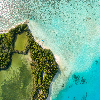

In [7]:
from IPython.display import Image, display, HTML

gamma_s = 1e-2
gamma_c = 1e-4
n_clusters = 2

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

visualize_clusters(kernel_k_means(K, n_clusters), h1, w1, "kernel_kmeans.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="normalized"), h1, w1, "normalized_cut.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="unnormalized"), h1, w1, "ratio_cut.gif")

display(Image(filename="image1.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))
display(HTML('<img src="normalized_cut.gif" width="100"/>'))
display(HTML('<img src="ratio_cut.gif" width="100"/>'))

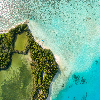

In [8]:
n_clusters = 3

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

visualize_clusters(kernel_k_means(K, n_clusters), h1, w1, "kernel_kmeans.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="normalized"), h1, w1, "normalized_cut.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="unnormalized"), h1, w1, "ratio_cut.gif")

display(Image(filename="image1.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))
display(HTML('<img src="normalized_cut.gif" width="100"/>'))
display(HTML('<img src="ratio_cut.gif" width="100"/>'))

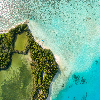

In [9]:
n_clusters = 4

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

visualize_clusters(kernel_k_means(K, n_clusters), h1, w1, "kernel_kmeans.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="normalized"), h1, w1, "normalized_cut.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="unnormalized"), h1, w1, "ratio_cut.gif")

display(Image(filename="image1.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))
display(HTML('<img src="normalized_cut.gif" width="100"/>'))
display(HTML('<img src="ratio_cut.gif" width="100"/>'))



image 2

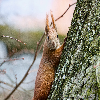

In [11]:
n_clusters = 2

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

visualize_clusters(kernel_k_means(K, n_clusters), h2, w2, "kernel_kmeans.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="normalized"), h2, w2, "normalized_cut.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="unnormalized"), h2, w2, "ratio_cut.gif")

display(Image(filename="image2.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))
display(HTML('<img src="normalized_cut.gif" width="100"/>'))
display(HTML('<img src="ratio_cut.gif" width="100"/>'))



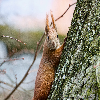

In [12]:
n_clusters = 3

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

visualize_clusters(kernel_k_means(K, n_clusters), h2, w2, "kernel_kmeans.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="normalized"), h2, w2, "normalized_cut.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="unnormalized"), h2, w2, "ratio_cut.gif")

display(Image(filename="image2.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))
display(HTML('<img src="normalized_cut.gif" width="100"/>'))
display(HTML('<img src="ratio_cut.gif" width="100"/>'))

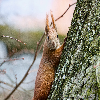

In [13]:
n_clusters = 4

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

visualize_clusters(kernel_k_means(K, n_clusters), h2, w2, "kernel_kmeans.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="normalized"), h2, w2, "normalized_cut.gif")
visualize_clusters(spectral_clustering(K, n_clusters, method="unnormalized"), h2, w2, "ratio_cut.gif")

display(Image(filename="image2.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))
display(HTML('<img src="normalized_cut.gif" width="100"/>'))
display(HTML('<img src="ratio_cut.gif" width="100"/>'))

Patt 3

In [15]:
def kmeans_plus_kernel(K, n_clusters):
    n = K.shape[0]
    centers_idx = [np.random.choice(n)]  # Randomly choose the first centroid

    for _ in range(1, n_clusters):
        # Ensure the chosen centroids are within the bounds
        if any(idx >= K.shape[1] for idx in centers_idx):
            raise ValueError(f"Index out of bounds in centers_idx: {centers_idx}")

        # Calculate the minimum distance of each point to the chosen centroids
        dist_to_centers = np.min(K[np.ix_(range(n), centers_idx)], axis=1)
        dist_to_centers = np.maximum(dist_to_centers, 1e-8)   # Avoid zero distance
        probabilities = dist_to_centers / dist_to_centers.sum()

        # Select the next centroid based on the calculated probabilities
        next_center_idx = np.random.choice(n, p=probabilities)
        centers_idx.append(next_center_idx)

    return centers_idx

def kernel_kmeans_plus(K, n_clusters, max_iter=10):
    n = K.shape[0]
    cluster_assignments_history = []  # Store the cluster assignments for each iteration

    # Initialize centroids using K-means++ method
    initial_centers_idx = kmeans_plus_kernel(K, n_clusters)

    # Initialize the cluster assignments for each point
    cluster_assignments = np.zeros(n, dtype=int)

    for iteration in range(max_iter):
        # Calculate the distance of each point to the centroids
        distances = np.zeros((n, n_clusters))
        for k, center_idx in enumerate(initial_centers_idx):
            # Use the kernel distance formula to calculate the distance
            distances[:, k] = (
                K.diagonal()
                - 2 * K[:, center_idx]
                + K[center_idx, center_idx]
            )

        # Assign each point to the closest centroid
        new_assignments = np.argmin(distances, axis=1)

        # Record the current cluster assignments
        cluster_assignments_history.append(new_assignments.copy())

        # Check if the algorithm has converged (assignments didn't change)
        if np.array_equal(new_assignments, cluster_assignments):
            break
        cluster_assignments = new_assignments

    return cluster_assignments_history


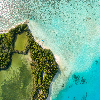

In [23]:
# 設定參數
n_clusters = 2

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

# 視覺化
visualize_clusters(kernel_kmeans_plus(K, n_clusters), h1, w1, "kernel_kmeans.gif")

display(Image(filename="image1.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))

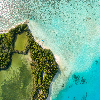

In [17]:
# 設定參數
n_clusters = 4

K = rbf_kernel(coordinates1, colors1, gamma_s, gamma_c)

# 視覺化
visualize_clusters(kernel_kmeans_plus(K, n_clusters), h1, w1, "kernel_kmeans.gif")

display(Image(filename="image1.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))

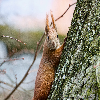

In [18]:
# 設定參數
n_clusters = 2

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

# 視覺化
visualize_clusters(kernel_kmeans_plus(K, n_clusters), h2, w2, "kernel_kmeans.gif")

display(Image(filename="image2.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))

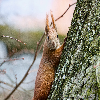

In [19]:
# 設定參數
n_clusters = 4

K = rbf_kernel(coordinates2, colors2, gamma_s, gamma_c)

visualize_clusters(kernel_kmeans_plus(K, n_clusters), h2, w2, "kernel_kmeans.gif")
display(Image(filename="image2.png"))
display(HTML('<img src="kernel_kmeans.gif" width="100"/>'))